In [6]:
#!/usr/bin/env python
# Ahmad Al - Imtiaz; email: ahmadal.imtiaz@gmail.com
# 11 Jan 2023

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as spo

In [5]:
#Data Observer frame
data = pd.read_excel(r"3c_273.xlsx")
wave_obs = np.array(data.spectral_axis) #[Angstrom]
flux_den_obs = np.array(data.intensity) #[erg/cm^2/s/A]

In [6]:
#Constants
z = 0.15834
dis_src = 760.5 #Mpc
dis_src = dis_src * 3.08567758e24 #cm
print(dis_src)
c = 3* 10**8 #m/s
f = 3/4
G = 6.6743 * (10**-11) #m^3/kg/s^2

2.34665779959e+27


In [7]:
#Source frame
wave_src = wave_obs/(1+z) #Angstrom
flux_den_src = flux_den_obs*(1+z) #erg/cm^2/s/A
lum_src = (flux_den_src * 4 * np.pi * dis_src**2) *wave_src #erg/s

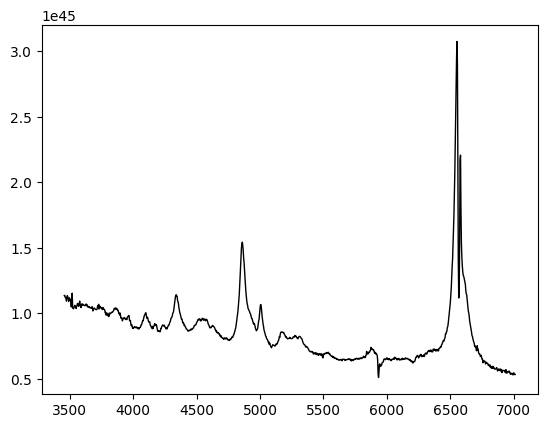

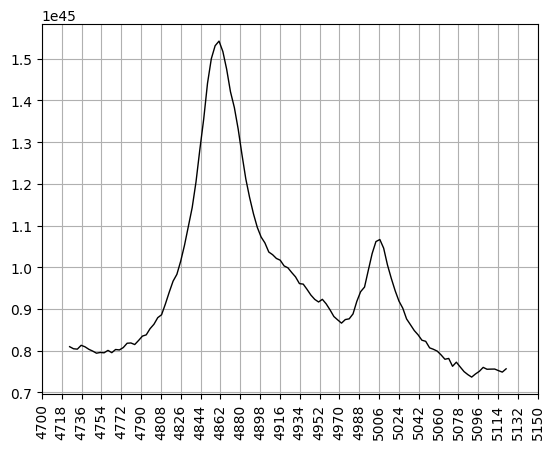

In [11]:
#ploting
plt.plot(wave_src, lum_src, "black", linewidth=1)
plt.show()

plt.plot(wave_src[365:480], lum_src[365:480], "black", linewidth=1)
plt.grid()
plt.xticks(np.linspace(4700,5150, 26), rotation = 90)
plt.show()

In [12]:
X = wave_src[365:480]
Y = lum_src[365:480]

In [13]:
#defining model

def model(x, amp1, mu1, sig1, c1,
          amp2, mu2, sig2, c2,
          amp3, mu3, sig3, c3,
          amp4, mu4, sig4, c4):
    
    func_val1 = c1 + amp1 * np.exp(-np.power(x - mu1, 2.)/(2 * np.power(sig1, 2.))) #HbetaNarrow
    func_val2 = c2 + amp2 * np.exp(-np.power(x - mu2, 2.)/(2 * np.power(sig2, 2.))) #Hbetabroad
    func_val3 = c3 + amp3 * np.exp(-np.power(x - mu3, 2.)/(2 * np.power(sig3, 2.))) #O[III]Narrow
    func_val4 = c4 + amp4 * np.exp(-np.power(x - mu4, 2.)/(2 * np.power(sig4, 2.))) #O[III]Broad
    
    return func_val1 + func_val2 + func_val3 + func_val4 - c2 - c3 - c4
    

In [14]:
#curve fitting

def gaussian(x, amp, mu, sig, c):
    func_val = c + amp * np.exp(-np.power(x - mu, 2.)/(2 * np.power(sig, 2.)))
    return func_val

initial_guess = [
                0.5*(10**45), 4860, 15, 0.8*(10**45),  #HbetaNarrow: amp1, mu1, sig1, c1
                0.3*(10**45), 4870, 55, 0.8*(10**45),  #Hbetabroad: amp2, mu2, sig2, c2
                0.19*(10**45), 5006, 9, 0.75*(10**45), #O[III]Narrow: amp3, mu3, sig3, c3
                0.13*(10**45), 5000, 18, 0.75*(10**45), #O[III]Broad: amp4, mu4, sig4, c4
            ]
bund = (
        (0.4*(10**45), 4850, 12, 0.77*(10**45),  #lower: HbetaNarrow: amp1, mu1, sig1, c1
        0.15*(10**45), 4860, 45, 0.77*(10**45), #lower: Hbetabroad: amp2, mu2, sig2, c2
        0.15*(10**45), 4995, 5, 0.70*(10**45), #lower: O[III]Narrow: amp3, mu3, sig3, c3
        0.08*(10**45), 4990, 13, 0.70*(10**45),  #lower: O[III]Broad: amp4, mu4, sig4, c4
        ), #All lower in a tuple
        
        (0.6*(10**45), 4870, 20, 0.83*(10**45), #upper: HbetaNarrow: amp1, mu1, sig1, c1
        0.45*(10**45), 4880, 60, 0.83*(10**45),  #upper: Hbetabroad: amp2, mu2, sig2, c2
        0.25*(10**45), 5036, 14, 0.76*(10**45), #upper: O[III]Narrow: amp3, mu3, sig3, c3
        0.17*(10**45), 5030, 24, 0.76*(10**45),  #upper: O[III]Broad: amp4, mu4, sig4, c4
        ) #All upper in a tuple
        
    )

popt, pcov = spo.curve_fit(model, X, Y, p0 = initial_guess, bounds = bund)
print(popt)
yfit = model(X, *popt)
yfit1 = gaussian(X, *popt[0:4])
yfit2 = gaussian(X, *popt[4:8])
yfit3 = gaussian(X, *popt[8:12])
yfit4 = gaussian(X, *popt[12:16])

[5.00000000e+44 4.86133017e+03 1.38191376e+01 8.00000000e+44
 3.00000000e+44 4.87155803e+03 5.29464878e+01 8.00000000e+44
 1.90000000e+44 5.00855719e+03 8.61574449e+00 7.50000000e+44
 1.30000000e+44 5.00106769e+03 1.80115502e+01 7.50000000e+44]


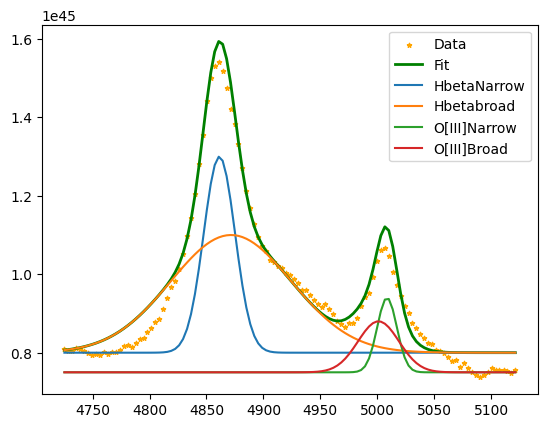

In [15]:
plt.scatter(X, Y, s=10, c='Orange', marker='*', label = "Data")
plt.plot(X, yfit, "green", linewidth=2, label = "Fit")
plt.plot(X, yfit1, label = "HbetaNarrow")
plt.plot(X, yfit2, label = "Hbetabroad")
plt.plot(X, yfit3, label = "O[III]Narrow")
plt.plot(X, yfit4, label = "O[III]Broad")
plt.legend()
plt.show()

In [17]:
#Finding values
lum_5100 = gaussian(5100, *popt[8:12]) #erg/s
print("O[III](5100)",lum_5100)
FWHM = 2.3548*popt[6] #need to correct for func2 
print("FWHM1",FWHM)
V = (c*FWHM)/4863 #m/s
R = 2.59* 10**13 * 10**(1.527 + (0.533*np.log10((lum_5100/(10**44))))) #m


M_BH = f * ((R*V**2)/G) #kg
M_BH = (M_BH/(1.989*10**30)) #Solar mass
print("Mass of BH:",M_BH, "Solar Masses")

O[III](5100) 7.499999999999999e+44
FWHM1 124.67838955295102
Mass of BH: 852598397.9529709 Solar Masses


## Finding FWHM using intercept

In [95]:
x = [4775, 5055, popt[5]]
halfmax = np.max(gaussian(X, *popt[4:8])-popt[7])/2 + popt[7]
y = [gaussian(x[0], *popt[4:8]), gaussian(x[1], *popt[12:16]), halfmax]
m = (y[1]-y[0])/(x[1]-x[0])
*values, = [m, x[2], y[2]]


def yl(x):
    return (values[0]*(x-values[1])) + values[2]
def yl1(x):
    return (m*(x-x[0])) + y[0]

def gaussian1(x):
    func_val = popt[7] + popt[4] * np.exp(-np.power(x - popt[5], 2.)/(2 * np.power(popt[6], 2.)))
    return func_val

def findIntersection(fun1,fun2, x0, x1):
    return spo.fsolve(lambda xr : fun1(xr) - fun2(xr),(x0,x1))

result = findIntersection(yl, gaussian1, 4835, 4885)
print(result)

[4815.45256333 4942.12211589]


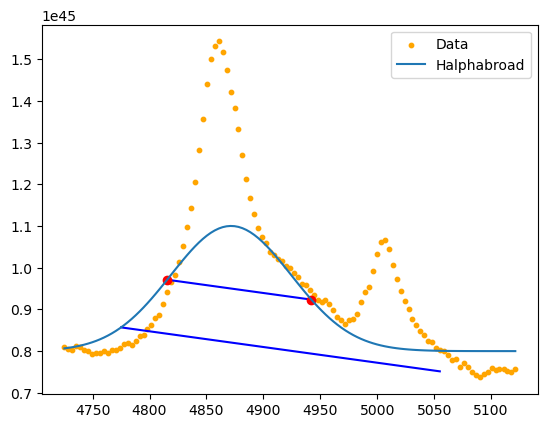

In [98]:
plt.scatter(X, Y, s=10, c='Orange', marker='o', label = "Data")
plt.plot(np.arange(result[0], result[1], 0.1), yl(np.arange(result[0], result[1], 0.1)), "blue", result, gaussian1(result), 'ro')
plt.plot(np.arange(x[0],x[1],0.1), yl1(np.arange(x[0],x[1],0.1)), "blue")
plt.plot(X, yfit2, label = "Halphabroad")
plt.legend()
plt.show()

In [99]:
#calculation with the corrected value of FWHM
FWHM = result[1] - result[0]
print("FWHM2",FWHM)
V = (c*FWHM)/4863 #m/s
M_BH = f * ((R*V**2)/G) #kg
M_BH = (M_BH/(1.989*10**30)) #Solar mass
print("M_BH2",M_BH)

FWHM2 126.66955255676385
M_BH2 880048520.8146162
